In [13]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import mxnet as mx
from mxnet import gluon
import pickle
import json
import random
import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from indycar.model.ZeroPredictor import ZeroPredictor
from pandas.plotting import register_matplotlib_converters
from gluonts.model.forecast import SampleForecast
register_matplotlib_converters()

#from indycar.model.stint_predictor_fastrun import *
import indycar.model.stint_simulator_shortterm_pitmodel as stint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def simulation(datasetid, testevent, taskid, runts, expid, predictionlen, 
               datamode, loopcnt, featuremode = stint.FEATURE_STATUS,
              pitmodel = 0):
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    stint.init(pitmodel)
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._train_len = 40
    predictor = stint.load_model(predictionlen, 'oracle',trainid='2018')

    ret2 = {}
    for i in range(loopcnt):
        ret2[i] = stint.run_simulation_shortterm(predictor, predictionlen, stint.freq, datamode=datamode)

    acc = []
    for i in ret2.keys():
        df = ret2[i]
        _x = stint.get_evalret_shortterm(df)
        acc.append(_x)

    b = np.array(acc)
    print(np.mean(b, axis=0))
    
    #save keys
    stint._pitmodel.save_keys('pitmodel-keys.pickle')
    
    return b, ret2

In [3]:
def test_pitmodel(modelfile, testevent, runts, loopcnt=10):
    #pitmodel-m60-mlp-e500-l10-10-5-student-d0.1.pickle
    if runts == 'RANK':
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                    'rank',stint.COL_RANK,'rank',
                   2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                      pitmodel=modelfile)        
    else:
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                        'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                       2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                          pitmodel=modelfile)

    print(np.mean(acc, axis=0)  )

In [28]:
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()

### test return full samples

In [6]:
pitmodel = 'pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle'
datasetid = 'indy2013-2018-nocarid-context40'
testevent = 'Indy500-2018'
featuremode =  stint.FEATURE_STATUS
taskid = 'rank'
runts = stint.COL_RANK
expid = 'rank'
datamode = stint.MODE_ORACLE_LAPONLY
predictionlen = 2

stint.init(pitmodel)
stint._dataset_id = datasetid
stint._test_event = testevent
#_test_event = 'Indy500-2019'

stint._feature_mode = featuremode
stint._context_ratio = 0.

stint._task_id = taskid  # rank,laptime, the trained model's task
stint._run_ts = runts   #COL_LAPTIME,COL_RANK
stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

stint._train_len = 40
predictor = stint.load_model(predictionlen, 'oracle',trainid='2018')


ret, full_samples, full_tss = stint.run_simulation_shortterm(predictor, predictionlen, stint.freq, datamode=datamode)

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
ERROR: key 14-45 not found in model


In [7]:
full_tss

{1: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  1.,  0.,  2., 12.,  4.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  4.,  4.,
         4.,  4.,  4.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  8., 19., 19., 19., 18., 18., 18., 19., 19.,
        19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 18., 16.,
        16., 12.,  9.,  5.,  3.,  2.,  2.,  2.,  2.,  8., 21., 20., 20.,
        19., 18., 15., 15., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
        14., 14., 14., 13., 13., 13., 13., 12., 11., 10.,  9.,  7.,  3.,
         1.,  1.,  0.,  0.,  7., 19., 18., 16., 16., 16., 14., 12., 12.,
        12., 11.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10., 10.,
         9.,  9.,  9.,  8.,  8.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        16., 17., 16., 14., 13., 13., 13., 12., 

In [11]:
full_samples[12][:,-1]

array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 3., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 0., 2., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 2., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 2., 0., 1., 0., 0., 0., 0., 0., 2., 0.,
       1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.])

In [17]:
testcar = 12
freq = '1min'
start = pd.Timestamp("01-01-2019", freq=freq) 
fc = SampleForecast(samples = full_samples[testcar][:, 12:], freq=freq, start_date=start + 12)

#index = pd.date_range(start, freq, periods = len(full_tss[testcar]))
#ts = pd.DataFrame(index = index, data = full_tss[testcar])

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  after removing the cwd from sys.path.


In [26]:
index = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))
ts = pd.DataFrame(index = index, data = full_tss[testcar])

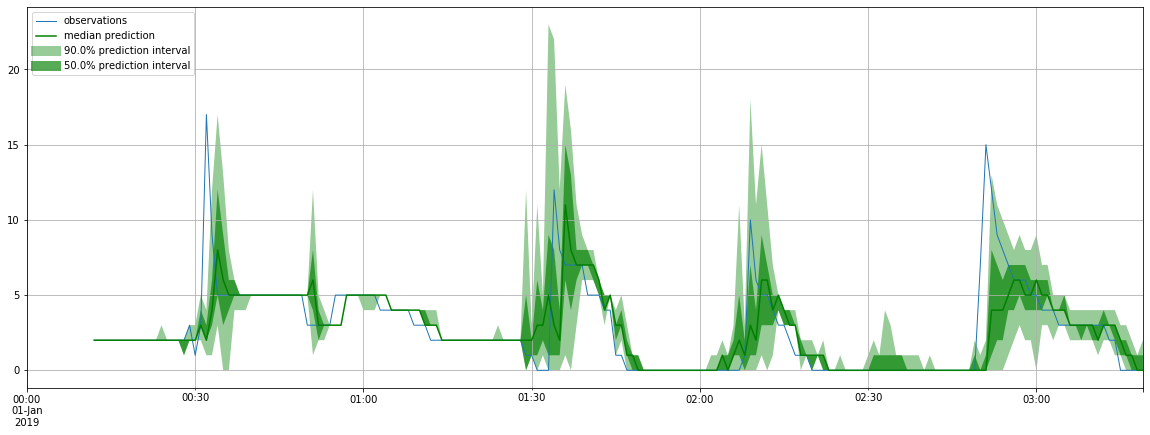

In [29]:
plot_prob_forecasts_ex([ts], [fc], 'output-car12')

In [18]:
fc

gluonts.model.forecast.SampleForecast(freq="1min", info=None, item_id=None, samples=numpy.array([[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 4.0, 2.0, 1.0, 10.0, 1.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 10.0, 0.0, 27.0, 0.0, 1.0, 27.0, 1.0, 7.0, 7.0, 7.0, 5.0, 5.0, 4.0, 5.0, 2.0, 4.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 5.0, 1.0, 1.0, 0.0, 3.0, 4.0, 4.0, 0.0, 4.0, 3.0, 4.0, 3.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 7.0, 2.0, 10.0, 4.0, 1.0, 6.0, 7.0, 3.0, 3.0, 7.0, 5.0, 4.0, 4.0, 4.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.

In [32]:
carlist = full_tss.keys()
tss = []
forecasts = []
forecasts_mean = []
freq = '1min'
start = pd.Timestamp("01-01-2019", freq=freq) 

for car in carlist:
    testcar = car
    fc = SampleForecast(samples = full_samples[testcar][:, 12:], freq=freq, start_date=start + 12)
    
    samples = np.mean(full_samples[testcar][:, 12:], axis =0, keepdims=True)
    fc_mean = SampleForecast(samples = samples, freq=freq, start_date=start + 12)
    
    index = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))
    ts = pd.DataFrame(index = index, data = full_tss[testcar])    
    
    tss.append(ts)
    forecasts.append(fc)
    forecasts_mean.append(fc_mean)
    



/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # Remove the CWD from sys.path while we load stuff.
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  del sys.path[0]


In [31]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(tss))
print(json.dumps(agg_metrics, indent=4)) 

Running evaluation: 100%|██████████| 33/33 [00:00<00:00, 143.75it/s]

{
    "MSE": 8.535151898491621,
    "abs_error": 6981.0,
    "abs_target_sum": 74024.0,
    "abs_target_mean": 14.542421627584766,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.14233560668152864,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4488.0,
    "Coverage[0.1]": 0.15189577819831543,
    "QuantileLoss[0.5]": 6981.0,
    "Coverage[0.5]": 0.2764556416307196,
    "QuantileLoss[0.9]": 4777.6,
    "Coverage[0.9]": 0.4536929340681747,
    "RMSE": 2.921498228390978,
    "NRMSE": 0.2008948924193849,
    "ND": 0.09430725170215065,
    "wQuantileLoss[0.1]": 0.06062898519399114,
    "wQuantileLoss[0.5]": 0.09430725170215065,
    "wQuantileLoss[0.9]": 0.06454122987139306,
    "mean_wQuantileLoss": 0.07315915558917828,
    "MAE_Coverage": 0.2405824008331404
}


In [33]:
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts_mean), num_series=len(tss))
print(json.dumps(agg_metrics, indent=4)) 

Running evaluation: 100%|██████████| 33/33 [00:00<00:00, 154.14it/s]

{
    "MSE": 8.535151898491621,
    "abs_error": 7142.1,
    "abs_target_sum": 74024.0,
    "abs_target_mean": 14.542421627584766,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.16559471770893705,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 7142.100000000001,
    "Coverage[0.1]": 0.48537260051297093,
    "QuantileLoss[0.5]": 7142.1,
    "Coverage[0.5]": 0.48537260051297093,
    "QuantileLoss[0.9]": 7142.100000000001,
    "Coverage[0.9]": 0.48537260051297093,
    "RMSE": 2.921498228390978,
    "NRMSE": 0.2008948924193849,
    "ND": 0.09648357289527722,
    "wQuantileLoss[0.1]": 0.09648357289527723,
    "wQuantileLoss[0.5]": 0.09648357289527722,
    "wQuantileLoss[0.9]": 0.09648357289527723,
    "mean_wQuantileLoss": 0.09648357289527724,
    "MAE_Coverage": 0.27154246649567637
}
